# COMP5703 - Capstone project CP-14 ---->

Original author: Pote Pongchaikul

## Preface

The code was originally designed for training on one dataset (containing many stocks) and testing on another data (again multi-stock).

## Preliminaries

In [0]:
!pip install -U -q PyDrive


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# PyDrive reference:
# https://googledrive.github.io/PyDrive/docs/build/html/index.html
# https://pythonhosted.org/PyDrive/



In [2]:
file_list = drive.ListFile({'q': "'1mWlUOJaz6IPibDYVw8Oz1Ps_04hNwJSu' in parents and trashed=false"}).GetList()
for file1 in file_list:
  print('title: %s, id: %s' % (file1['title'], file1['id']))

title: MAIN edition COMP5703 project code.ipynb, id: 1IwGrPx0ScQ1z0B3OOy5EBisvDTGbM-iT
title: test MAIN.ipynb, id: 1vjNKndUIkQZ6SQZsxRs0I_OkdaCdI3Ad
title: ASX200_ASX50 edition COMP5703 project code.ipynb, id: 1CXNmMURZodOrqdZOj0ltMyuBzbAdY9lJ
title: COMP5703 Project code 1.ipynb, id: 1hDXK8bn-zpmzGzvIXBddWhSohkY0yEN6
title: INDEX version of project code.ipynb, id: 1H8FzkIRn8Jk7TAHcA0rs7gYog7PhhrIO
title: Project timeline, id: 1Hg82YX1iJozlaclxmHSCxqrVplQh81HYfyL1Hw4BZU4
title: Capstone_Create_Datasets_27Aug18.ipynb, id: 1anV2YNGlCdiL3tBRUa5G7uNkmVWPDPkW
title: Scribble notes, id: 1AyZhQVkclpd0NqWdU02yM23gELcRDLYV8iU-1FXeni0
title: OLD, id: 1bKKKo4QNg1omQ_ejH3_ntUu_EMwLJvv-


## Import packages

In [3]:
## For state space modelling
## Ref: https://pydlm.github.io/installation.html, accessed 5 September
!pip install pydlm
!pip install seaborn
!pip install wbdata



    100% |████████████████████████████████| 51kB 1.9MB/s 
  Running setup.py bdist_wheel for pydlm ... - \ done
  Stored in directory: /root/.cache/pip/wheels/d3/64/7f/99427e6464ff5f8561889ab4f001422a69e1f59636790b9f91
Successfully built pydlm
  Running setup.py bdist_wheel for wbdata ... - done
  Stored in directory: /root/.cache/pip/wheels/57/61/6a/3978e90cf2f9443b94ce56b4fa839850da9076e697be3a27e3
Successfully built wbdata


In [0]:
## Import packages
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt

## Ref: https://pydlm.github.io/pydlm_user_guide.html#modeling, accessed 5 September
from pydlm import dlm, dynamic


## Import dataset

The array dataset_list will be used later to indicate whether we are dealing with training data or testing data. It is also important for adjusted_data_df_original, which will be used as main_data variable later. By default, the first index of dataset_list shall refer to testing data. 

* adjusted_data_df_original: dictionary that consists of adjusted_data.csv (S&P500 and ASX200) downloaded from github. 

In [0]:
## Adjusted data 1: ASX200
## Adjusted data 2: S&P500 set 1
## Adjusted data 3: S&P500 set 2
## Adjusted data 4: S&P500 set 3


adjusted_data_ASX = pd.read_csv("https://raw.github.sydney.edu.au/asha7190/MI_FinancialTrading/master/Code_old/adjusted_data.csv?token=AAAH4bQYtoFgmMMCIs74ciLBtD3taWFxks5bw_MpwA%3D%3D",
                           index_col=0, parse_dates=True)

adjusted_data_SP500_1 = pd.read_csv("https://raw.github.sydney.edu.au/asha7190/MI_FinancialTrading/master/Code_old/S%26P500%20Data/sp500_adjusted_data_1.csv?token=AAAH4ffHgmhs-El1ALefeRD0kBuh95fdks5bw_NWwA%3D%3D",
                           index_col=0, parse_dates=True)

adjusted_data_SP500_2 = pd.read_csv("https://raw.github.sydney.edu.au/asha7190/MI_FinancialTrading/master/Code_old/S%26P500%20Data/sp500_adjusted_data_2.csv?token=AAAH4XXEjrUCX3IsffbgqrhaSaLcwcosks5bw_O4wA%3D%3D",
                           index_col=0, parse_dates=True)

adjusted_data_SP500_3 = pd.read_csv("https://raw.github.sydney.edu.au/asha7190/MI_FinancialTrading/master/Code_old/S%26P500%20Data/sp500_adjusted_data_3.csv?token=AAAH4fxQy7QhSXOVnBn_KWBRs9GSj573ks5bw_PSwA%3D%3D",
                           index_col=0, parse_dates=True)



dataset_list = ["ASX","SP500_1","SP500_2","SP500_3"]
adjusted_data_df_original = {"ASX":adjusted_data_ASX, "SP500_1":adjusted_data_SP500_1,
                     "SP500_2":adjusted_data_SP500_2, "SP500_3":adjusted_data_SP500_3}


We are renaming columns so that capitalization, lower case and upper case letters match that of Dr. Khushi's code.

In [0]:
## Rename columns and to drop some columns that appeared redundant

for data in dataset_list:
  
  ## Rename columns:
  ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html, accessed 3 September
  adjusted_data_df_original[data] = adjusted_data_df_original[data].rename(columns = {"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"})

  ## Drop columns: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html, accessed 16 September
  #adjusted_data_df_original[data] = adjusted_data_df_original[data].drop(columns = ["dividend_amount",	"split_coefficient"])



In [7]:
adjusted_data_df_original["SP500_3"].tail()

,Open,High,Low,Close,adjusted_close,Volume,dividend_amount,split_coefficient,symbol
date,,,,,,,,,
2018-09-17,89.06,89.2800,88.030,88.30,88.30,1667207,0.0,1.0,ZTS
2018-09-18,88.17,89.4850,88.150,89.18,89.18,1722348,0.0,1.0,ZTS
2018-09-19,89.14,89.6900,88.790,89.08,89.08,2273387,0.0,1.0,ZTS
2018-09-20,89.72,90.5000,89.315,90.06,90.06,3428300,0.0,1.0,ZTS
2018-09-21,90.03,90.9341,89.790,89.83,89.83,3448374,0.0,1.0,ZTS


### Import and merge World bank data

In [0]:


#World Bank API

# Data Acquisition

# For citation purposes:

# Sherouse, Oliver (2014). Wbdata. Arlington, VA. Available from http://github.com/OliverSherouse/wbdata.

# Documentation: https://wbdata.readthedocs.io/en/latest/index.html

#Load libraries
import wbdata
import pandas as pd
import matplotlib.pyplot as plt
import datetime

#import pandas_datareader.data as web

from matplotlib.dates import date2num
from matplotlib.dates import num2date
import matplotlib.dates as mpld
import numpy as np

#List of information sources (indicators groups/categories)

#wbdata.get_source()


#Search indicator code

#wbdata.get_indicator(source=6)

#Search for countries or indicators
#wbdata.search_countries("New")
#wbdata.search_indicators("debt")
#country_list=wbdata.get_country(display=False)
#country_list[0]
#all_countries={}
#for country in country_list:
#    all_countries[country['id']]=country['name']

#Get Data Demo
#countries2=["AUS","ARG","BRA","USA"]
#indicators2 = {'NY.GDP.PCAP.CD':'GDP per Capita', 'NY.GDP.DEFL.KD.ZG':'Inflation'}
#df = wbdata.get_dataframe(indicators2, country=countries2, convert_date=False)
#dfu = df.unstack(level=0)
#plt.figure(figsize=(15,5))
#plt.subplot(121)
#plt.plot(dfu['GDP per Capita']);plt.title('GDP per Capita');plt.xlabel('Date');
#plt.legend(dfu['GDP per Capita']);plt.xticks(rotation='vertical', size=8)
#plt.subplot(122)
#plt.plot(dfu['Inflation'][-20:]);plt.title('Inflation');plt.xlabel('Date');
#plt.legend(dfu['Inflation']);plt.xticks(rotation='vertical')
#plt.show()
#df.head()


#Print list of indicator categories and count
#indicator_details=wbdata.get_indicator(source=2, display=False)
#categories={}
#
#for indicator in indicator_details:
#    if len(indicator['topics'])>0:
#        if indicator['topics'][0]['value'] in categories:
#            categories[indicator['topics'][0]['value']]+=1
#        else:
#            categories[indicator['topics'][0]['value']]=1
#
#for category in categories:
#    print(category, categories[category])


#Input for the function
countries=['AUS','CHN']
indicators={'NY.GDP.PCAP.PP.CD':'GDP per capita, PPP (current international $)',
               'NY.GDP.MKTP.CD':'GDP (current US$)',
               'NY.GDP.DEFL.KD.ZG':'Inflation, GDP deflator (annual %)',
               'DT.DOD.DSTC.IR.ZS':'Short-term debt (% of total reserves)',
               'GC.DOD.TOTL.GD.ZS':'Central government debt, total (% of GDP)',
               'FP.CPI.TOTL.ZG':'Inflation, consumer prices (annual %)',
               'FI.RES.TOTL.CD':'Total reserves (includes gold, current US$)',
               'NV.IND.TOTL.CD':'Industry (including construction), value added (current US$)',
               'NV.IND.MANF.CD':'Manufacturing, value added (current US$)',
               'NE.TRD.GNFS.ZS':'Trade (% of GDP)',
               }


data_date = (datetime.datetime(1999, 1, 1), datetime.datetime(2018, 9, 1))

#To inspect indicator categories

#for indicator in indicator_details:
#    if len(indicator['topics'])>0:
#        if indicator['topics'][0]['value']=='Health ':
#            print("'",indicator['id'],"'",':',"'", indicator['name'],"'", sep='')


#Get the data
def get_wbdataframe(indicators, data_date, countries):
    df=wbdata.get_dataframe(indicators=indicators, 
                            data_date=data_date, 
                            convert_date=True, 
                            country=countries) 
    df=df.unstack(level=0)
    df.columns=['-'.join(col).strip() for col in df.columns.values]
    ## print(df.shape, 'Shape with null columns')
    df=df.loc[:,(df.sum(axis=0)!=0)]
    df=df.dropna(axis='columns', how='all')
    ## print(df.shape, 'Shape without null columns')
    
    return df

#df= get_wbdataframe(indicators, data_date, countries)

#df.to_csv('wb_data.csv', index=True)



In [0]:

def merge_wbdata(stock,stock_abb):

  #from get_wb_data import get_wbdataframe, indicators, countries, data_date
  #stock=adjusted_data_df_original[data]

  #Get Wb data from csv
  ##wb_data=pd.read_csv('wb_data.csv', index_col=0, parse_dates=True).astype(np.float32)

  #Get Wb data from api
  wb_data=get_wbdataframe(indicators, data_date, countries)

  #Create dataframe for a single stock
  temp_df=stock.loc[stock.symbol==stock_abb]
  temp_df.sort_index(inplace=True)

  temp_df=pd.merge_asof(temp_df, wb_data, left_index=True, 
                    right_index=True, tolerance=pd.Timedelta(days=731))
  return temp_df



## Feature engineering

These are taken from project proposal, but might need further revision

1. Price o Normalized to a similar scale
2. Volume
3. Moving average: Test different periods: 5, 10, 20, 50, 100, 150, 200, 250 day periods
4. Momentum: Change in price over periods: 1-250 days
5. Exponentially weighted moving average: Test different periods: 5, 10, 15, 20, 25, 30 days and different exponential weights
6. Volatily: Test different periods: 5, 10, 20, 50, 100, 150, 200, 250 day periods
7. Autocorrelation: Test different periods. In this specific case we shall feature autocorrelation between 10-250 days.
8. Relative Strength Index, RSI: We shall engineer RSI data for periods from 5 to 250 days.
9. Standard deviation of price: Test different periods: 5-50 days
10. Volume traded moving average: Test different periods: 5, 10, 20, 50, 100, 150, 200, 250 day periods
11. On balance volume (sum volume if price increases, deduct if it decreases): Test different periods
12. Money flow index: Similar to on-balance volume, measures volume and price. We intend to test for different periods
13. Apart from doing extensive feature engineering we also intend to do Spectral Analysis using Fourier Transformation of stock-price time series.

### Feature engineering

We acknowledge Dr. M. Khushi for his assistance.

In [0]:
#######################################
## Feature engineering
### Acknowledgment: Dr. Matloob Khushi 
#######################################

## define functions to calculate technical indicators - SET 1

def SMA(data,period):
    temp_df = pd.DataFrame()
    temp_df['Close'] = data
    return np.array(temp_df.Close.rolling(period).mean())

def WMA(data,period):
    temp = []
    for i in np.arange(0,len(data)):
        if i < period-1:
            temp.append(np.nan)
        else:
            num, denom  = 0, 0
            for j in np.arange(0,period):
                num += (period - j) * data[i-j]
                denom += (period - j)
            temp.append(num / denom)
    return np.array(temp)

def Momentum(data,period):
    temp_df = pd.DataFrame()
    temp_df['Close'] = data
    return np.array(temp_df.Close - temp_df.Close.shift(period))

def Stochastic_K(close,high,low,period=14):
#     %K = 100(C - L14)/(H14 - L14)
#     Where:
#     C = the most recent closing price
#     L14 = the low of the 14 previous trading sessions
#     H14 = the highest price traded during the same 14-day period
    temp_df = pd.DataFrame()
    temp_df['Close'] = close
    temp_df['High'] = high
    temp_df['Low'] = low
    
    temp_df['Sto_K'] = ((temp_df.Close - temp_df.Low.rolling(period).min()) / \
                        (temp_df.High.rolling(period).max() - temp_df.Low.rolling(period).min()))
    
    return np.array(temp_df.Sto_K.values) * 100

def Stochastic_D(sto_k,period=3):
#     %K = 100(C - L14)/(H14 - L14)
#     Where:
#     C = the most recent closing price
#     L14 = the low of the 14 previous trading sessions
#     H14 = the highest price traded during the same 14-day period
    temp_df = pd.DataFrame()
    temp_df['Sto_k'] = sto_k
    temp_df['Sto_d'] = temp_df.Sto_k.rolling(period, center = False).mean()
    
    return np.array(temp_df.Sto_d.values)

##  RSI function
def RSI(data, period):
    # data is a np array, period is size of window
    temp_df = pd.DataFrame()
    temp_df['Close'] = data
    temp_df['Change'] = temp_df.Close - temp_df.Close.shift(1)
    temp_df['Up'] = [i if i>=0 else np.nan for i in temp_df.Change]
    temp_df['Down'] = [-i if i<0 else np.nan for i in temp_df.Change]
    temp_df['Ave_gain'] = temp_df.Up.rolling(period, min_periods = 1).sum()/period
    temp_df['Ave_loss'] = temp_df.Down.rolling(period, min_periods = 1).sum()/period
    temp_df['RS'] = temp_df.Ave_gain / temp_df.Ave_loss
    temp_df['RSI'] = (100 - (100 / (1 + temp_df['RS']))) 
    temp = np.array(temp_df.RSI.values)
    temp[:period-1] = np.nan
    
    return temp

def Williams_R(close,high,low,period=14):
# %R = (highest high – closing price) / (highest high – lowest low) x -100
    temp_df = pd.DataFrame()
    temp_df['Close'] = close
    temp_df['High'] = high
    temp_df['Low'] = low
    
    temp_df['Wil_R'] = ((temp_df.High.rolling(period).max() - temp_df.Close) / \
                        (temp_df.High.rolling(period).max() - temp_df.Low.rolling(period).min()))
    
    return np.array(temp_df.Wil_R.values) * -100

def MACD(close):
# The MACD is calculated by subtracting the 26-day exponential moving average (EMA) 
# from the 12-day EMA. A nine-day EMA of the MACD, called the "signal line", is then 
# plotted on top of the MACD, functioning as a trigger for buy and sell signals

    temp_df = pd.DataFrame()
    temp_df['Close'] = close
    MACD = np.array(temp_df.Close.ewm(span = 12).mean() - temp_df.Close.ewm(span = 26).mean())
    temp_df2 = pd.DataFrame()
    temp_df2['MACD'] = MACD
    Signal = np.array(temp_df2.MACD.ewm(span = 9).mean())

    return MACD - Signal

def Accum_Ditrib(close,high,low,volume):
# 1. Money Flow Multiplier = [(Close  -  Low) - (High - Close)] /(High - Low) 
# 2. Money Flow Volume = Money Flow Multiplier x Volume for the Period
# 3. ADL = Previous ADL + Current Period's Money Flow Volume
# https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:accumulation_distribution_line

    temp_df = pd.DataFrame()
    temp_df['Close'] = close
    temp_df['High'] = high
    temp_df['Low'] = low
    temp_df['Volume'] = volume
    
    temp_df['MFM'] = ((temp_df.Close - temp_df.Low) - (temp_df.High - temp_df.Close)) / (temp_df.High - temp_df.Low)
    temp_df['MFV'] = temp_df.MFM * temp_df.Volume
    temp_df['ADL'] = np.cumsum(temp_df.MFV.values)
    

    return np.array(temp_df.ADL.values)


def CCI(close,high,low):
    
# CCI = (Typical Price  -  20-period SMA of TP) / (.015 x Mean Deviation)
# Typical Price (TP) = (High + Low + Close)/3
# Constant = .015
# There are four steps to calculating the Mean Deviation: 
# First, subtract the most recent 20-period average of the typical price from each period's typical price. 
# Second, take the absolute values of these numbers. 
# Third, sum the absolute values. 
# Fourth, divide by the total number of periods (20). 
# https://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci

# The definition of overbought or oversold varies for the Commodity Channel Index (CCI). 
# ±100 may work in a trading range, but more extreme levels are needed for other situations. 
# ±200 is a much harder level to reach and more representative of a true extreme

    temp_df = pd.DataFrame()
    temp_df['Close'] = close
    temp_df['High'] = high
    temp_df['Low'] = low
    temp_df['TP'] = temp_df['High'] + temp_df['Low'] + temp_df['Close']
    temp_df['SMA20'] = temp_df.TP.rolling(20,center = False).mean()
    
    temp_df['Mean_Dev'] = np.zeros(len(temp_df))
    for i in np.arange(0,20):
        temp_df['Mean_Dev'] += np.abs(temp_df.TP.shift(i)-temp_df.SMA20)
    temp_df.Mean_Dev = temp_df.Mean_Dev /20
    
    temp_df['CCI'] = (temp_df.TP - temp_df.SMA20) / (0.015 * temp_df.Mean_Dev)

    return np.array(temp_df.CCI.values)





In [0]:
#######################################
## Feature engineering
### Acknowledgment: Dr. Matloob Khushi 
#######################################

## define trend deterministic functions from technical indicators

def T_SMA(sma, close):
    return np.where(close>sma,1,np.where(close<sma,-1,0))

def T_WMA(wma, close):
    return np.where(close>wma,1,np.where(close<wma,-1,0))

    # return +1 if sto_k at time t > sto_k at time t-1, and visa versa (0 if neither)
def T_Sto_K(sto_k):
    # insert 0 in front instead of np.nan
    return np.insert(np.where(sto_k[1:]>sto_k[:-1], 1, np.where(sto_k[1:]<sto_k[:-1], -1, 0)),0,0)

def T_Sto_D(sto_d):
    # return +1 if sto_d at time t > sto_d at time t-1, and visa versa (0 if neither)
    # insert 0 in front instead of np.nan
    return np.insert(np.where(sto_d[1:]>sto_d[:-1], 1, np.where(sto_d[1:]<sto_d[:-1], -1, 0)),0,0)

def T_Williams_R(data):
    # return +1 if sto_d at time t > sto_d at time t-1, and visa versa (0 if neither)
    # insert 0 in front instead of np.nan
    return np.insert(np.where(data[1:]>data[:-1], 1, np.where(data[1:]<data[:-1], -1, 0)),0,0)

def T_MACD(data):
    # return +1 if data at time t > data at time t-1, and visa versa (0 if neither)
    # insert 0 in front instead of np.nan
    return np.insert(np.where(data[1:]>data[:-1], 1, np.where(data[1:]<data[:-1], -1, 0)),0,0)

def T_RSI(data):
    # If the value of RSI exceeds 70 level, it means that the stock
    # is overbought, so, it may go down in near future (indicating opinion
    # ‘-1’) and if the value of RSI goes below 30 level, it means that
    # the stock is oversold, so, it may go up in near future (indicating
    # opinion ‘+1’). For the values between (30, 70), if RSI at time ‘t’ is
    # greater than RSI at time ‘t-1’, the opinion on trend is represented t
    # as ‘+1’ and vice-a-versa
    
    return np.where(data>70,-1,np.where(data<30,1,\
                                       np.insert(np.where(data[1:]>data[:-1], 1, np.where(data[1:]<data[:-1], -1, 0)),0,0)\
                                       ))


def T_CCI(data):
    # CCI is also used for identifying overbought and oversold levels
    # This means that if CCI value exceeds 200 level, the opinion for
    # the trend is ‘-1’ and if it is below -200 level then the opinion
    # for the trend is ‘+1’. For the values between (-200, 200), if CCI at
    # time ‘t’ is greater than CCI at time ‘t-1’, the opinion on the trend
    # is ‘+1’ and vice-a-versa
    
    return np.where(data>200,-1,np.where(data<-200,1,\
                                       np.insert(np.where(data[1:]>data[:-1], 1, np.where(data[1:]<data[:-1], -1, 0)),0,0)\
                                       ))

def T_AD(data):
    # A/D oscillator also follows the stock trend meaning that if its value at time ‘t’ 
    # is greater than that at time ‘t-1’, the opinion on trend is ‘+1’ and vice-a-versa
    # insert 0 in front instead of np.nan
    
    return np.insert(np.where(data[1:]>data[:-1], 1, np.where(data[1:]<data[:-1], -1, 0)),0,0)

def T_Momentum(data):
    # Momentum measures the rate of rise and fall of stock prices. 
    # Positive value of momentum indicates up trend and is represented by ‘+1’ 
    # while negative value indicates down trend and is represented as ‘-1'

    return np.where(data>0,1,np.where(data<0,-1,0))






In [0]:
#######################################
## Feature engineering
### Acknowledgment: Dr. Matloob Khushi 
#######################################

# define functions to calculate second set of technocal indicators

def OBV(close, volume):
    theta = np.where(close[1:] > close[:-1],1,np.where(close[1:] < close[:-1],-1,0))
    theta = np.insert(theta,0,0)
    
    temp = []
    
    for i in  np.arange(0,len(close)):
        if i == 0:
            temp.append(0)
        else:
            temp.append(temp[-1] + (theta[i] * volume[i]))
    
    return temp

def Bias(close, period):
    
    ma = SMA(close,period)
    
    return 100 * (close - ma) / ma

def ASY(close, periods):
    
    SY = np.insert(100 * (np.log(close[1:]) - np.log(close[:-1])),0,0)
    temp_df = pd.DataFrame()
    temp_df['SY'] = np.insert(100 * (np.log(close[1:]) - np.log(close[:-1])),0,0)
    
    return temp_df.SY.rolling(periods).mean()

def PSY(close,period):
    # number of rsising days in period
    theta = np.where(close[1:] > close[:-1],1,np.where(close[1:] < close[:-1],-1,0))
    theta = np.insert(theta,0,0)
    
    temp_df = pd.DataFrame()
    temp_df['rising'] = theta
    
    return temp_df.rising.rolling(period).sum().values / period



In [0]:
#######################################
## Feature engineering
### Acknowledgment: Dr. Matloob Khushi 
#######################################

# functions to determin gain or loss in future

def Move(data, periods):
    
    temp_df = pd.DataFrame()
    temp_df['Close'] = data

    return np.array(temp_df.Close.shift(-periods) / temp_df.Close)

def T_Move(data):
    # return 1 if Move (data) > 0, -1 if <0, otherwise 0
    return np.where(data>1,1,np.where(data<1,-1,0))
    
def High(high, close, periods):
    # calculat the ratio of 1) the highest price over next period days, divided by 2) current close
    
    temp_df = pd.DataFrame()
    temp_df['High'] = high
    temp_df['Close'] = close

    return np.array(pd.rolling_max(temp_df.High.shift(-1)[::-1], window=periods, min_periods=0)[::-1]/ temp_df.Close)

def Low(low, close, periods):
    # calculate the ratio of 1) the lowest price over next period days, divided by 2) current close
    
    temp_df = pd.DataFrame()
    temp_df['Low'] = low
    temp_df['Close'] = close

    return np.array(pd.rolling_min(temp_df.Low.shift(-1)[::-1], window=periods, min_periods=0)[::-1]/ temp_df.Close)



In [0]:


######################################
def exponential_smoothing(data_df):
  
  ## Exponentially weighted Moving Average 

  ## Reference:
  ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html, accessed 31 August

  alpha = [0.25,0.5,0.75] ## weights

  for k in alpha:
    data_df["EWMA-"+str(k)] = data_df.Close.ewm(com = k).mean()
    if np.sum(np.asarray(data_df["EWMA-"+str(k)].isna() == True)) > 0:
      data_df["EWMA-"+str(k)] = data_df["EWMA-"+str(k)].fillna(method = "bfill") ## Imputation
    else:
      continue
  return data_df

def volatility(data_df): 
  ## Volatility

  ## References
  ## https://chrisalbon.com/python/data_wrangling/pandas_moving_average/, accessed 31 August
  ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isna.html, accessed 31 August
  ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna, accessed 31 August

  periods_moving_average = [100,150,200,250]
  for k in periods_moving_average:
    data_df["Volatility-"+str(k)] = data_df.Close.rolling(window = k).std()
    if np.sum(np.asarray(data_df["Volatility-"+str(k)].isna() == True)) > 0:
      data_df["Volatility-"+str(k)] = data_df["Volatility-"+str(k)].fillna(method = "bfill") ## Imputation
    else:
      continue
  return data_df
    
    
  
def autocorrelation(data_df):
  ## Autocorrelation 

  ## References
  ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.autocorr.html, 1 September
  autocorr_array = []
  threshold_lag = 250
  row,col = np.shape(data_df)
  k = 0
  while k < row:
    if k >= threshold_lag:
      autocorr_array.append(0)
    else:
      autocorr_array.append(data_df.Close.autocorr(lag = k))
    k = k+1

  data_df["autocorrelation"] = autocorr_array
  return data_df

def volume_traded_MA(data_df):

  ## References
  ## https://chrisalbon.com/python/data_wrangling/pandas_moving_average/, accessed 31 August
  ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.isna.html, accessed 31 August
  ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html#pandas.DataFrame.fillna, accessed 31 August

  periods_moving_average = [100,150,200,250]
  for k in periods_moving_average:
    data_df["Volume_MA-"+str(k)] = data_df.Volume.rolling(window = k).mean()
    if np.sum(np.asarray(data_df["Volume_MA-"+str(k)].isna() == True)) > 0:
      data_df["Volume_MA-"+str(k)] = data_df["Volume_MA-"+str(k)].fillna(method = "bfill") ## Imputation
    else:
      continue
  return data_df  


### Technical analysis

In [15]:
"""
## TECHNICAL ANALYSIS:

## VERSION 2.0 looks at last 3 days of momentum
## Version 2.1 looks at last 1 day of momentum which is a calculation of last 5 days of momentum (As defined in the Matloob function)

def candlestick_pattern(data,pattern):
  
  if pattern == "Hammer v2.0":

    ## Hammer v2.0:

    pattern_list = []
    alpha = 0.98
    beta = 0.98
    for i in range(3,data.shape[0]):
        count = 0 
        ## Checking Momentum
        for j in range(3):
            if data["T_Momentum"][i-1-j] == -1:
                count = count + 1
        ## Must be on a downward trend (last 3 days downward). 
        if count == 3:
            ## stock must trade signficantly lower than its opening during the day
            if data["Low"][i] < alpha*data["Open"][i]:
                ## stock must rally to close significantly above its opening
                if data["Close"][i]*beta > data["Open"][i]:
                    ## The tail should be at least twice the size of the candlestick body
                    if data["Open"][i] - data['Low'][i] >= 2*(data['Close'][i]-data['Open'][i]):
                        pattern_list.append(i)
    
    return pattern_list
  
  elif pattern == "Shooting Star v2.0":
  
    ## Shooting Star v2.0:

    pattern_list = []
    alpha = 1.03
    for i in range(3,data.shape[0]):
        count = 0 
        ## Checking Momentum
        for j in range(3):
            if data["T_Momentum"][i-1-j] == 1:
                count = count + 1
        ## Must be on an uptrend (last 3 days)   
        if count ==3:
            ## Stock must have a high significantly greater than its opening 
            if data["High"][i] > alpha*data["Open"][i]:
                ## Despite this stock falls and closes lower than its opening
                if data["Close"][i] < data["Open"][i]:
                    ## distance between high and open must be more than twice as the body
                    if data["High"][i] - data["Open"][i] > 2*np.absolute(data["Open"][i] - data["Close"][i]):
                        pattern_list.append(i)

    return pattern_list
  
  
  elif pattern == "Three line strike v2.0":
    ## Three line strike v2.0: 

    pattern_list = []
    for i in range(6,data.shape[0]):
        count = 0
        ## Checking Momentum
        for j in range(3,6):
            if data["T_Momentum"][i-1-j] == -1:
                count = count + 1
        ## Must be in a donward trend (last 3 days)
        if count == 3:
            ## Must have 4 bars all having lower lows than the next and 4th opening even lower
            if data["Low"][i-3] > data["Low"][i-2] > data["Low"][i-1] > data["Open"][i]:
                ## Final bar must close for greater than the high of the first bar in the series
                if data["Close"][i] > data["High"][i-3]:
                    pattern_list.append(i)
    
    return pattern_list
  
  elif pattern == "Morning Star v2.0":
    ## Morning Star v2.0:

    alpha = 1.03
    beta = 1.03
    pattern_list = []
    for i in range(5,data.shape[0]):
        count = 0 
        for j in range(2,5):
            if data["T_Momentum"][i-1-j] == -1:
                count = count + 1
        ## Must be in a downtrend
        if count == 3:
            ## First bar must close significantly lower than the opening
            if data["Close"][i-2]*alpha < data["Open"][i-2]:
                ## 2nd bar must open for less than first bar and close for less than first bar:
                if data["Open"][i-1] < data["Open"][i-2] and data["Close"][i-1] < data["Close"][i-2]:
                    ## Final bar shows a strong resergence and closes for significantly more then it opens for 
                    if data["Close"][i] > data["Open"][i]*beta:
                        pattern_list.append(i)
    
    return pattern_list
  
  elif pattern == "Bullish Abandoned baby v2.1":
  ## Bullish Abandoned baby v2.1: 

    pattern_list = []
    alpha = 1.01
    beta = 1.01
    for i in range(3, data.shape[0]):
        ## Check the day before the pattern to see if we are on a downward trend
        if data["T_Momentum"][i-3] == -1:
            ## First bar must be bearish
            if data["Close"][i-2] < data["Open"][i-2]:
                ## Second bar closes for lower than the lowest point of the first bar
                if data["Close"][i-1] < data["Low"][i-2]:
                    ## Second bar must also be a doji candle (Very small body):
                    if np.absolute(data["Close"][i-1]-data["Open"][i-1]) < 0.01*data["Close"][i-1]:
                        ## Third bar must open for significantly greater than the 2nd bar close.
                        if data["Close"][i-1]*alpha < data["Open"][i]:
                            ## Finally first bar must close for significantly more than it opened for
                            if data["Close"][i] > data["Open"][i]*beta:
                                pattern_list.append(i)
  
    return pattern_list
  
  
  elif pattern == "Morning Star v2.1":
    ## Morning Star v2.1:

    alpha = 1.03
    beta = 1.05
    pattern_list = []
    for i in range(3,data.shape[0]):
        ## Check the day before the pattern to see if we are on a downward trend
        if data["T_Momentum"][i-3] == -1:
            ## First bar must close significantly lower than the opening
            if data["Close"][i-2]*alpha < data["Open"][i-2]:
                ## 2nd bar must gap such that its body does not touch body of prior bar:
                if np.max([data["Close"][i-1],data["Open"][i-1]]) < data["Close"][i-2]:
                    ## Final bar shows a strong resergence and closes for significantly more then it opens for 
                    if data["Close"][i] > data["Open"][i]*beta:
                        pattern_list.append(i)

    return pattern_list
  
  elif pattern == "Three line strike v2.1":
  ## Three line strike v2.1: 

    pattern_list = []
    for i in range(4,data.shape[0]):
        ## Check the day before the pattern to see if we are on a downward trend
        if data["T_Momentum"][i-4] == -1:
            ## Must have 4 bars all having lower lows than the next and 4th opening even lower
            if data["Low"][i-3] > data["Low"][i-2] > data["Low"][i-1] > data["Open"][i]:
                ## Final bar must close for greater than the high of the first bar in the series
                if data["Close"][i] > data["High"][i-3]:
                    pattern_list.append(i)
    
    return pattern_list
  
  elif pattern == "Hammer v2.1":
    ## Hammer v2.1:

    pattern_list = []
    alpha = 0.98
    beta = 0.98
    for i in range(3,data.shape[0]):
        ## Check the day before the pattern to see if we are on a downward trend
        if data["T_Momentum"][i-1] == -1:
            ## stock must trade signficantly lower than its opening during the day
            if data["Low"][i] < alpha*data["Open"][i]:
                ## stock must rally to close significantly above its opening
                if data["Close"][i]*beta > data["Open"][i]:
                    ## The tail should be at least twice the size of the candlestick body
                    if data["Open"][i] - data['Low'][i] >= 2*(data['Close'][i]-data['Open'][i]):
                        pattern_list.append(i)
    return pattern_list
  
  elif pattern == "Shooting Star v2.1":
    ## Shooting Star v2.1:

    pattern_list = []
    alpha = 1.03
    for i in range(3,data.shape[0]):
         ## Check the day before the pattern to see if we are on an uptrend
        if data["T_Momentum"][i-1] == 1:
            ## Stock must have a high significantly greater than its opening 
            if data["High"][i] > alpha*data["Open"][i]:
                ## Despite this stock falls and closes lower than its opening
                if data["Close"][i] < data["Open"][i]:
                    ## distance between high and open must be more than twice as the body
                    if data["High"][i] - data["Open"][i] > 2*np.absolute(data["Open"][i] - data["Close"][i]):
                        pattern_list.append(i)
    return pattern_list
  
  else:
    print("Wrong type of candlestick pattern")
    


def results_observer(data,pattern):
  pattern_list = candlestick_pattern(data,pattern)
  ## Results observer v2.0 (Requires running one of the candlestick pattern code blocks first: 
  closes = []
  new_prices = []
  for index in pattern_list:
      closes.append(data["Close"][index])
      new_prices.append(data["Close"][index+1])

  increase_count = 0 
  zero_count = 0
  decrease_count = 0
  for i in range(len(new_prices)):
      if new_prices[i] == closes[i]:
          zero_count = zero_count + 1
      elif new_prices[i] > closes[i]:
          increase_count = increase_count + 1
      elif new_prices[i] < closes[i]:
          decrease_count = decrease_count + 1 

  print("Increase likelihood is: ", increase_count/(len(new_prices)))
  print("No movement liklihood is: ", zero_count/(len(new_prices)))
  print("Decrease liklihood is: ", decrease_count/(len(new_prices)))

  return {"Increase probability":increase_count,"Probability of no movement":zero_count,"Decrease probability":decrease_count}
  
  
## To convert a pattern list into a column:

def make_column(data,pattern,title):
  pattern_list = candlestick_pattern(data,pattern)
  column = []
  for i in range(data.shape[0]):
    if i in pattern_list:
      column.append(1)
    else:
      column.append(0)
  data[title] = column
  
## Example
    
## make_column(pattern_list, "shooting star")
"""


'\n## TECHNICAL ANALYSIS:\n\n## VERSION 2.0 looks at last 3 days of momentum\n## Version 2.1 looks at last 1 day of momentum which is a calculation of last 5 days of momentum (As defined in the Matloob function)\n\ndef candlestick_pattern(data,pattern):\n  \n  if pattern == "Hammer v2.0":\n\n    ## Hammer v2.0:\n\n    pattern_list = []\n    alpha = 0.98\n    beta = 0.98\n    for i in range(3,data.shape[0]):\n        count = 0 \n        ## Checking Momentum\n        for j in range(3):\n            if data["T_Momentum"][i-1-j] == -1:\n                count = count + 1\n        ## Must be on a downward trend (last 3 days downward). \n        if count == 3:\n            ## stock must trade signficantly lower than its opening during the day\n            if data["Low"][i] < alpha*data["Open"][i]:\n                ## stock must rally to close significantly above its opening\n                if data["Close"][i]*beta > data["Open"][i]:\n                    ## The tail should be at least twice t

### feature_engineer function

Compile every features from Dr. Khushi's code to merge with world bank data features.

In [0]:
## A function that performs feature engineering 
## Acknowledgment: Dr. Matloob Khushi 


def feature_engineer(data_original):
  symbol_asx = data_original.symbol
  adjusted_data_df = data_original
    
  ## add columns to adjusted_data_df dataframe
  # Name and technical indicators

  adjusted_data_df['SMA'] = SMA(adjusted_data_df.Close.values,10)
  adjusted_data_df['WMA'] = WMA(adjusted_data_df.Close.values,10)
  adjusted_data_df['Momentum'] = Momentum(adjusted_data_df.Close.values,10)
  adjusted_data_df['RSI'] = RSI(adjusted_data_df.Close.values,10)
  adjusted_data_df['Sto_K'] = Stochastic_K(adjusted_data_df.Close.values,adjusted_data_df.High.values,adjusted_data_df.Low.values,14)
  adjusted_data_df['Sto_D'] = Stochastic_D(adjusted_data_df.Sto_K.values,3)
  adjusted_data_df['Wil_R'] = Williams_R(adjusted_data_df.Close.values,adjusted_data_df.High.values,adjusted_data_df.Low.values,14)
  adjusted_data_df['MACD'] = MACD(adjusted_data_df.Close.values) # MACD - Signal
  adjusted_data_df['AD'] = Accum_Ditrib(adjusted_data_df.Close.values,adjusted_data_df.High.values,adjusted_data_df.Low.values,adjusted_data_df.Volume.values)
  adjusted_data_df['CCI'] = CCI(adjusted_data_df.Close.values,adjusted_data_df.High.values,adjusted_data_df.Low.values)
  # Trend deterministic technical indicators

  ## Could take into consideration later
  adjusted_data_df['T_SMA'] = T_SMA(adjusted_data_df.SMA.values,adjusted_data_df.Close.values)
  adjusted_data_df['T_WMA'] = T_WMA(adjusted_data_df.WMA.values,adjusted_data_df.Close.values)
  adjusted_data_df['T_Sto_K'] = T_Sto_K(adjusted_data_df.Sto_K.values)
  adjusted_data_df['T_Sto_D'] = T_Sto_D(adjusted_data_df.Sto_D.values)
  adjusted_data_df['T_Wil_R'] = T_Williams_R(adjusted_data_df.Wil_R.values)
  adjusted_data_df['T_MACD'] = T_MACD(adjusted_data_df.MACD.values)
  adjusted_data_df['T_RSI'] = T_RSI(adjusted_data_df.RSI.values)
  adjusted_data_df['T_CCI'] = T_CCI(adjusted_data_df.CCI.values)
  adjusted_data_df['T_AD'] = T_AD(adjusted_data_df.AD.values)
  adjusted_data_df['T_Momentum'] = T_Momentum(adjusted_data_df.Momentum.values)


  # Set 2 Technical Indicators
  adjusted_data_df['OBV'] = OBV(adjusted_data_df.Close.values,adjusted_data_df.Volume.values)
  adjusted_data_df['SMA_5'] = SMA(adjusted_data_df.Close.values,5)
  adjusted_data_df['Bias'] = Bias(adjusted_data_df.Close.values,6)
  adjusted_data_df['PSY'] = PSY(adjusted_data_df.Close.values,12)
  for i in np.arange(1,6): ## Removed for loops below for speed
    adjusted_data_df['ASY'+str(i)] = ASY(adjusted_data_df.Close.values,i)

    # Gain/Loss x days ahead
    #for i in np.arange(1,11):
    temp = "Move"+str(i)
    adjusted_data_df[temp] = Move(adjusted_data_df.Close.values,i)

    #for i in np.arange(1,11):
    temp = "T_Move"+str(i)
    temp1 = "Move"+str(i)
    adjusted_data_df[temp] = T_Move(adjusted_data_df[temp1].values)

    #for i in np.arange(1,11):
    temp = "High"+str(i)
    adjusted_data_df[temp] = High(adjusted_data_df.High.values,adjusted_data_df.Close.values,i)

    #for i in np.arange(1,11):
    temp = "Low"+str(i)
    adjusted_data_df[temp] = Low(adjusted_data_df.Low.values,adjusted_data_df.Close.values,i)


  exponential_smoothing(adjusted_data_df)
  volatility(adjusted_data_df)
  autocorrelation(adjusted_data_df)
  volume_traded_MA(adjusted_data_df)
  
  """
  pattern_array = ["Hammer v2.0","Shooting Star v2.0","Three line strike v2.0","Morning Star v2.0",
                "Bullish Abandoned baby v2.1","Morning Star v2.1","Three line strike v2.1",
                "Hammer v2.1","Shooting Star v2.1"]
  
  for pattern in pattern_array:
    adjusted_data_df[pattern] = make_column(adjusted_data_df,pattern,title = pattern)
  """
  
  return adjusted_data_df

  

### Set indices for later use (training dataset)

To choose which stock to train and which to test, it was agreed that random choosing be done. This is accomplished by fixing the testing data index (as mentioned before) and to choose, randomly, the training data. Since we have three S&P500 dataset, the maximum index, starting from 1, we can choose is 4. This corresponds to choosing an integer randomly from 1, 2, 3 in index_array_dataset_list (it gives the array of index from the dataset_list defined).

In addition, once the index was chosen, we must also choose the subset of stocks randomly. Here, it was chosen arbitrarily the maximum stock number, which can go as high as 150 (or other desired index if needed). The index_array_name_list gives the index array for the names of stocks to choose (hence the name index_array_name_list). The size of the index (train_size) will be the size of the training data. We also chose the size of the test data to be 10. Again this can be changed.

In [17]:
## Setting indices for later use #############

## Set seed for random shuffling
np.random.seed(1)

## To use with dataset_list
## Using random integers
## https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.random_integers.html#numpy.random.random_integers, accessed 6 October
max_index_dataset_list = 4
index_array_dataset_list = np.random.random_integers(low = 1, high = max_index_dataset_list)
print(index_array_dataset_list)

## To use with name_list
## Set threshold at 200 arbitrarily
train_size = 20 ## Training data set size

## Sorting array:
## https://www.programiz.com/python-programming/methods/built-in/sorted
## accessed 7 October
index_array_name_list = np.unique(sorted(np.random.random_integers(low = 1,size = train_size,high = 150),reverse = False))
print(len(index_array_name_list))

## Size of dataset to left out for testing
test_size = 10


2
20


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: This function is deprecated. Please call randint(1, 4 + 1) instead
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: This function is deprecated. Please call randint(1, 150 + 1) instead


### Perform feature engineering using the *feature_engineer* function

To make our predictive model usable for testing data, feature engineering must be performed on both training and testing data. This means we have to loop through the testing data index (zeroth index of dataset_list) and the randomly chosen training index, which is given by index_array_dataset_list. Additionally, every stock for a given training and testing data index will also need to be feature engineered. We access the stocks via the use of name_list (name list of stocks).

* Convention: Any stock will be accessed from the adjusted data by first access its name (index corresponding to the "versions" of S&P500 or ASX200), then the stock for that index will be used.

In [18]:
## Removing duplicates:
## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html accessed 7 September

adjusted_data_df_subset = {}
adjusted_data_df_merge = {}
adj_data_df_subset = {}

## Recall:
dataset_list = ["ASX","SP500_1","SP500_2","SP500_3"]

dataset_list = [dataset_list[0],dataset_list[index_array_dataset_list]]
print(dataset_list)

for data in dataset_list: ## Adjust this so that runtime is reduced 
  
  ## Adjust this so that runtime is reduced 
  name_list = adjusted_data_df_original[data].symbol.drop_duplicates()[index_array_name_list]
  
  
  row,col = np.shape(adjusted_data_df_original[data])
  adjusted_data_df_subset[data] = {}
  adjusted_data_df_merge[data] = {}
  adj_data_df_subset[data] = {}

  for name in name_list:
    
    
    adjusted_data_df_subset[data][name] = adjusted_data_df_original[data].loc[adjusted_data_df_original[data].symbol == name,:]
    adjusted_data_df_merge[data][name] = merge_wbdata(adjusted_data_df_subset[data][name],name)
    
    adj_data_df_subset[data][name] = feature_engineer(adjusted_data_df_merge[data][name])
    




['ASX', 'SP500_2']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in less
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/pyth

### Normalize

Perform normalization via the perform_normalize function. This is done "column-wise", and to eliminate the burden of dealing with missing values, any column with missing values are ignored. We also do not wish to overwrite the original adjusted data, so we created a dictionary to store these (adj_data_df work, which will be the adjusted data which we will work with). But we must keep the original data for accessing the stock and stock names, though original adjusted data will not be used for training purposes.

In [0]:
def normalize(data):
  ## Standard deviation in Numpy
  ## https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html, accessed 17 September
  return (data - np.mean(data))/np.std(data)

In [0]:
## Perform normalization

## Drop columns:
## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
## accessed 21 September

def perform_normalize():
  adj_data_df_work = {}
  for data in dataset_list[:max_index_dataset_list]:
    adj_data_df_work[data] = {}
    name_list = adjusted_data_df_original[data].symbol.drop_duplicates()[index_array_name_list]
    for name in name_list:
      adj_data_df_work[data][name] = adj_data_df_subset[data][name].dropna(axis = "columns",how = "any")
      adj_data_df_work[data][name] = adj_data_df_work[data][name].drop(columns = "symbol")
      for cc in adj_data_df_work[data][name].columns:
        adj_data_df_work[data][name][cc] = normalize(adj_data_df_work[data][name][cc])

  return adj_data_df_work


In [0]:
adj_data_df_work = perform_normalize()


In [0]:
## A list of stock names for reference
## Note: this is only for reference purposes.

def print_keys():
  name_store = {}
  for data in dataset_list[:max_index_dataset_list]:
    name_store[data] = {}
    name_list = adjusted_data_df_original[data].symbol.drop_duplicates()[index_array_name_list]
    for name in name_list:
      name_store[data][name] = [data,name,np.shape(adj_data_df_work[data][name])]
  return name_store

store_name = print_keys()

In [23]:
store_name

{'ASX': {'ASX:AST': ['ASX', 'ASX:AST', (3208, 51)],
  'ASX:BAP': ['ASX', 'ASX:BAP', (1100, 51)],
  'ASX:CPU': ['ASX', 'ASX:CPU', (4753, 50)],
  'ASX:FMG': ['ASX', 'ASX:FMG', (4753, 50)],
  'ASX:FPH': ['ASX', 'ASX:FPH', (4262, 50)],
  'ASX:GNC': ['ASX', 'ASX:GNC', (4753, 50)],
  'ASX:GUD': ['ASX', 'ASX:GUD', (4753, 50)],
  'ASX:ILU': ['ASX', 'ASX:ILU', (4753, 50)],
  'ASX:IRE': ['ASX', 'ASX:IRE', (4536, 50)],
  'ASX:LLC': ['ASX', 'ASX:LLC', (4753, 50)],
  'ASX:ORI': ['ASX', 'ASX:ORI', (4753, 50)],
  'ASX:PGH': ['ASX', 'ASX:PGH', (1186, 51)],
  'ASX:PLS': ['ASX', 'ASX:PLS', (2764, 51)],
  'ASX:PRY': ['ASX', 'ASX:PRY', (4753, 50)],
  'ASX:QAN': ['ASX', 'ASX:QAN', (4753, 50)],
  'ASX:QBE': ['ASX', 'ASX:QBE', (4753, 50)],
  'ASX:QUB': ['ASX', 'ASX:QUB', (2944, 51)],
  'ASX:REA': ['ASX', 'ASX:REA', (4753, 50)],
  'ASX:RIO': ['ASX', 'ASX:RIO', (4753, 50)],
  'ASX:RRL': ['ASX', 'ASX:RRL', (4752, 50)]},
 'SP500_2': {'HBAN': ['SP500_2', 'HBAN', (5974, 37)],
  'HES': ['SP500_2', 'HES', (5974, 37)

## Exploratory analysis - Optional

We cancreate plots in order to explore the attributes as part of the process of data cleaning. Since the data size is extremely large, our exploratory analysis will need to restrict to a certain subset. This section is optional, and is meant only for visual examination.

In [24]:
"""
## Testing only for AAPL data
aapl = adj_data_df_work["SP500_1"]["AAPL"]
aapl.columns
"""

'\n## Testing only for AAPL data\naapl = adj_data_df_work["SP500_1"]["AAPL"]\naapl.columns\n'

### Assessing correlation structures - Heatmap

This is to explore correlation structures and to look for clusters. If there are clusters, we could then perform some dimensionality reduction on those clusters.

In [0]:
## Function to create heatmap. This will be used to explore correlation structures

def heatmap_plot(data_name,stock_abb,chosen_attr):
  ## For "stock_abb": Put "ASX:" then put the desired stock abbreviation
  ## adj_data_df_work is a dictionary with key = stock name, values = dataset for that stock
  ## Chosen attribute: Numerical column index chosen
  
  adj_data_df = adj_data_df_work[data_name][stock_abb]
  adj_data_df = adj_data_df.iloc[:,chosen_attr]
  corr_mat = np.matrix(adj_data_df.corr())
  ## Seaborn heatmap:
  ## https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap, accessed September 9
  plt.figure(figsize = (15,15))
  sns.heatmap(adj_data_df.corr(),annot = True)
  plt.title("Heatmap plot for "+str(stock_abb))
  plt.show()

  ## Computation of eigenvalues:
  ## https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigvals.html, accessed 16 September
  ## https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html?highlight=correlation%20matrix, accessed 17 September

def eigen_stuff(data_name,stock_abb,chosen_attr):
  adj_data_df = adj_data_df_work[data_name][stock_abb]
  adj_data_df = adj_data_df.iloc[:,chosen_attr]
  evals,evec = np.linalg.eig(np.corrcoef(adj_data_df))
  
  ## Taking real part:
  ## https://docs.scipy.org/doc/numpy/reference/generated/numpy.real.html, accessed 18 September
  
  return evals, evec
  


In [26]:
"""
aapl = adj_data_df_work["SP500_1"]["AAPL"]
heatmap_plot("SP500_1","AAPL",range(10,24))
"""

'\naapl = adj_data_df_work["SP500_1"]["AAPL"]\nheatmap_plot("SP500_1","AAPL",range(10,24))\n'

### Time series plot

In [27]:
"""
## Plotting
## Idea of time series plot:
## http://pandas.pydata.org/pandas-docs/version/0.13/visualization.html, accessed 2 October
for data in dataset_list:
  print(data)  
  for name in name_list[:4]:
    plt.figure(figsize = (15,8))
    print(adj_data_df_work[data][name].Close)
    sns.tsplot(adj_data_df_work[data][name].Close)
    plt.title(name)
    plt.show()
    
""" 

'\n## Plotting\n## Idea of time series plot:\n## http://pandas.pydata.org/pandas-docs/version/0.13/visualization.html, accessed 2 October\nfor data in dataset_list:\n  print(data)  \n  for name in name_list[:4]:\n    plt.figure(figsize = (15,8))\n    print(adj_data_df_work[data][name].Close)\n    sns.tsplot(adj_data_df_work[data][name].Close)\n    plt.title(name)\n    plt.show()\n    \n'

## Data analysis using State-space model

Sources that could be used:

- https://docs.scipy.org/doc/numpy-1.10.4/reference/generated/numpy.matrix.tolist.html (accessed 5 September)
- https://pydlm.github.io/pydlm_user_guide.html#modeling, accessed 5 September
- https://pydlm.github.io/example1.html#dynamic-linear-regression, accessed 5 September
- https://github.com/wwrechard/pydlm/blob/master/doc/source/pydlm_user_guide.rst, accessed 11 September


### Prepare data for processing with _pydlm_ package

The pydlm package requires some manipulation on the structures of the data. For example, list of lists will be needed for the training response to be fed into the dlm package in order to perform dynamic linear model.

In [0]:
def prepare_train(data_name_train,train_size, train_data, main_data):

  response_train = {}
  feature_matrix_dd_train = {}

  ## AD did not appear in ASX, so in order to have the same number of columns,
  ## AD must also be removed for SP500_1
  column_drop = ["Close","adjusted_close","Open","High","Low"]


  ## Train on S&P500, test on ASX ########################
  ## Create training set for S&P500

  ## data_train: SP500_1

  finished = 0

  while finished == 0: ## While the execution is not finished
    data = data_name_train
    print("Name of training data:",data)
    response_train[data] = {}
    feature_matrix_dd_train[data] = {}

    ## name_list for training set
    ## Use the first 20 indices

    name_list_train = list(main_data[data].symbol.drop_duplicates()[index_array_name_list[:train_size]])

    for name_tr in name_list_train: 
      response_train[data][name_tr] = list(train_data[data][name_tr].loc[:,"Close"])

      ## Convert pandas object to list:
      ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.tolist.html (accessed 21 September)

      ## Drop a column
      ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html (accessed 21 September)

      ## Convert data type:
      ## https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html#numpy.ndarray.astype
      ## accessed 21 September
      response_train[data][name_tr] = [[r] for r in train_data[data][name_tr].loc[:,"Close"]]
      feature_matrix_dd_train[data][name_tr] = np.matrix(train_data[data][name_tr].drop(columns = column_drop)).astype(dtype = "float").tolist()

    finished = finished + 1

  return name_list_train, feature_matrix_dd_train, response_train

### Create data matrix for the test set (to be fed into prediction in _pydlm_)

In [0]:
## Create test set 

def prepare_test(data_name_test, test_size, test_data, main_data):

  response_test = {}
  feature_matrix_dd_test = {}
  column_drop = ["Close","adjusted_close","Open","High","Low"]


  finished = 0 

  while finished == 0: ## While the execution is not finished
    data = data_name_test
    response_test[data] = {}
    feature_matrix_dd_test[data] = {}
    data = data_name_test

    length_name_list_test = len(list(main_data[data].symbol.drop_duplicates()))
    name_list_test = list(main_data[data].symbol.drop_duplicates()[index_array_name_list[:test_size]])

    for name_te in name_list_test:
      num_row = test_data[data][name_te].shape[0]
      
      ## data_name_test, name_list_test
      response_test[data][name_te] = test_data[data][name_te].Close.iloc[index_array_name_list[:test_size]]

      ## Convert pandas object to list:
      ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.tolist.html (accessed 21 September)

      ## Drop a column
      ## https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html (accessed 21 September)

      ## Convert data type:
      ## https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html#numpy.ndarray.astype
      ## accessed 21 September

      ##
      feature_matrix_dd_test[data][name_te] = np.matrix(test_data[data][name_te].iloc[index_array_name_list[:test_size]].
                                                        drop(columns = column_drop)).astype(dtype = "float").tolist()
    finished = finished + 1

  return name_list_test, feature_matrix_dd_test, response_test

### Implement the dynamic linear model to obtain prediction mean

The implementation will yield the predicted mean and others such as predicted variance for the five test observations. However, for some stocks, the predicted mean will be missing. Thus, we will take on the method of imputing the mean value of the training response values for that stock. This is done in the impute_missing_pred_mean function.

In [0]:
def run_state_space(data_name_train, train_size, train_data, main_data):
  
  name_list_train, feature_matrix_dd_train, response_train = prepare_train(data_name_train, train_size, train_data, main_data)

  ## This stores the dlm object, and this will be indexed by stock names in training data
  mydlm = {}


  name_list_train = list(main_data[data].symbol.drop_duplicates()[index_array_name_list[:train_size]])

  for name_tr in name_list_train: 
    print("=========",name_tr,"============")

    mydlm[name_tr] = {}

    mydlm[name_tr] = dlm(response_train[data][name_tr]) + dynamic(features = 
                                                                 feature_matrix_dd_train[data][name_tr],
                                                                 discount = 1,name = name_tr)
    mydlm[name_tr].fitForwardFilter()
   
  return name_list_train, mydlm, response_train

### A look at the latent states ($\beta$ coefficients)

These coefficients correspond to "slope". We will use the last coefficient, because this will correspond to the latest update of the states. Note that prediction for testing data corresponds to (feature matrix for testing data) * (latest state estimate). _Proof might be given in the final report if required or agreed among group members_

In [0]:
## Get coefficients for the state-space model (DLM) ###############

def get_latent_state(data_name_train, train_size, train_data, main_data):

  #data_train = dataset_list[1]
  #data_name_test = dataset_list[0]

  name_list_train, mydlm, response_train = run_state_space(data_name_train, train_size, train_data, main_data)

  latent_coef_mean = {}
  latent_coef_var = {}
  our_state = {}

  for name_tr in name_list_train: 
    print("=========",name_tr,"============")
    latent_coef_mean[name_tr] = mydlm[name_tr].getLatentState(filterType = "forwardFilter")
    latent_coef_var[name_tr] = mydlm[name_tr].getLatentCov(filterType = "forwardFilter")

    our_state[name_tr] = latent_coef_mean[name_tr][len(latent_coef_mean[name_tr])-1]
    if np.sum(np.isnan(latent_coef_mean[name_tr]) == True) > 0:
      our_state[name_tr] = [np.mean(response_train[data_name_train][name_tr])]*len(our_state[name_tr])
    else:
      our_state[name_tr] = latent_coef_mean[name_tr][len(latent_coef_mean[name_tr])-1]

    our_state[name_tr] = np.reshape(our_state[name_tr],newshape = (len(our_state[name_tr]),1))
    print(our_state[name_tr])
    print("\n")
    
  return our_state

In [0]:
def predict_test_train(data_name_train, data_name_test, test_size, test_data, train_size, train_data, main_data):
  
  name_list_test, feature_matrix_dd_test, response_test = prepare_test(data_name_test,test_size,test_data,main_data)
  name_list_train, feature_matrix_dd_train, response_train = prepare_train(data_name_train,train_size,train_data,main_data)
  
  our_state = get_latent_state(data_name_train, train_size, train_data, main_data)
  
  ##data_train
  pred_test_train = {}
  
  for name_te in name_list_test:
    pred_test_train[name_te] = {} 
    for name_tr in name_list_train:
      if np.shape(our_state[name_tr])[0] == np.shape(feature_matrix_dd_test[data_name_test][name_te])[1]:
        pred_test_train[name_te][name_tr] = list(np.dot(feature_matrix_dd_test[data_name_test][name_te],our_state[name_tr]).flatten())
        if np.sum(np.isnan(pred_test_train[name_te][name_tr]) == True) > 0:
          pred_test_train[name_te][name_tr] = response_train[data_name_train][name_tr][len(response_train[data_name_train][name_tr]) - 1] + np.nan_to_num(pred_test_train[name_te][name_tr])
      else:
        pred_test_train[name_te][name_tr] = np.nan_to_num(our_state[name_tr]) + response_train[data_name_train][name_tr][len(response_train[data_name_train][name_tr]) - 1]

  return name_list_train, name_list_test, pred_test_train, response_test

### Error calculation and performance analysis

We will need to see how the prediction performs against the test observations. The metric we will use are mean-squared error, mean absolute percentage error, and absolute percentage error. Each of these will be carried out twice, one for the prediction on the normalized test data, and another on the original scale.

To undertake performance analysis on the original scale, we multiply the predictions with the standard deviation of the original close values (for each stock), and add the mean, again from the original close values. This is an inverse transformation that brings the prediction into the original space from the normalized space.

In [0]:
## Compute error and fill in missing values (NaN)
## It is assumed that if missing values occur, then it can be replaced
## by the mean value

def error_MSE(pred,truth):
  error_sq = [(p-t)**2 for p,t in zip(pred,truth)]
  MSE = np.mean(error_sq)
  return MSE

In [0]:
## De-normalize - to get to the original scale

def get_parameter(data_name_test,name_test):
  ## Standard deviation in Numpy
  ## https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html, accessed 17 September
  std = np.std(adj_data_df_subset[data_name_test][name_test].loc[:,"Close"])
  mean = np.mean(adj_data_df_subset[data_name_test][name_test].loc[:,"Close"])
  
  return mean, std

In [0]:
def MSE_on_normalize(data_name_train, data_name_test, test_size, test_data, train_size, train_data, main_data):

  name_list_train, name_list_test, prediction_mean_imp, response_test = predict_test_train(data_name_train, data_name_test, test_size, test_data, train_size, train_data, main_data)

  MSE_error_pred = {}

  for name_te in name_list_test: 
    MSE_error_pred[name_te] = {}
    for name_tr in name_list_train:
      MSE_error_pred[name_te][name_tr] = error_MSE(prediction_mean_imp[name_te][name_tr],response_test[data_name_test][name_te])
      
  return MSE_error_pred

In [0]:
## Prediction of stocks - Original scale

def predict_test_train_original(data_name_train, data_name_test, test_size, test_data, train_size, train_data, main_data):

  name_list_train, name_list_test, prediction_mean_imp, response_test = predict_test_train(data_name_train, data_name_test, test_size, test_data, train_size, train_data, main_data)
  
  ## MSE and RMSE
  MSE_pred_original_scale = {}
  RMSE_pred_original_scale = {}
  pred_original_scale = {}
  response_test_original_scale = {}


  ## Original data from above (unnormalized): adjusted_data_df_subset[data][name]

  ## response_test[data][name_te]

  for name_te in name_list_test: 
    pred_original_scale[name_te] = {}
    MSE_pred_original_scale[name_te] = {}
    RMSE_pred_original_scale[name_te] = {}

    std_temp, mean_temp = get_parameter(data_name_test,name_te)


    ## Response transformed to original scale
    response_test_original_scale[name_te] = [std_temp*y + mean_temp for y in response_test[data_name_test][name_te]]

    for name_tr in name_list_train:    
      pred_original_scale[name_te][name_tr] = [std_temp*y + mean_temp for y in prediction_mean_imp[name_te][name_tr]]

      MSE_pred_original_scale[name_te][name_tr] = error_MSE(pred_original_scale[name_te][name_tr],response_test_original_scale[name_te])
      RMSE_pred_original_scale[name_te][name_tr] = np.sqrt(MSE_pred_original_scale[name_te][name_tr])


      print("RMSE for:",name_tr,"-",name_te,"=",RMSE_pred_original_scale[name_te][name_tr])
      print("\n")

  return MSE_pred_original_scale, RMSE_pred_original_scale, pred_original_scale, response_test_original_scale


We will create visualizations for prediction performance (RMSE and MSE). Running performance_plot will run the commands from prepare_train, and create the plots.

In [0]:
def performance_plot(data_name_train, data_name_test, test_size, test_data, train_size, train_data, main_data):

  MSE_pred_original_scale, RMSE_pred_original_scale, pred_original_scale, response_test_original_scale = predict_test_train_original(data_name_train, data_name_test, test_size, test_data, train_size, train_data, main_data)

  performance_data = pd.DataFrame.from_dict(RMSE_pred_original_scale)
  for q in range(len(performance_data.columns)):
    print("================","RMSE:",performance_data.columns[q],"==================")
    print("Mean",np.mean(performance_data.iloc[:,q]))
    print("Median",np.median(performance_data.iloc[:,q]))
    print("Standard deviation",np.std(performance_data.iloc[:,q]))
    print("\n")

  plt.figure()
  sns.boxplot(data = performance_data,orient = "h")
  plt.xlabel("RMSE")
  plt.show()



Name of training data: SP500_2
Name of training data: SP500_2
========= HBAN ============
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
========= HES ============
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
========= INTU ============
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
========= JWN ============
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
========= KHC ============
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
========= KIM ============
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
========= KR ============
Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


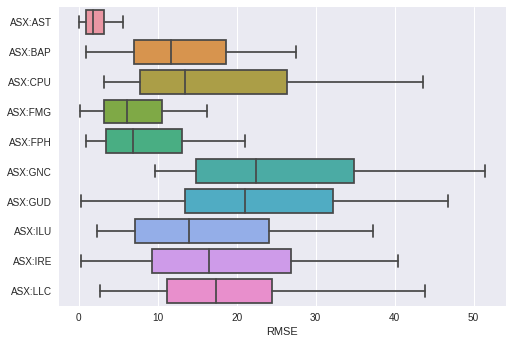

In [78]:
performance_plot(data_name_train = dataset_list[1], 
                 data_name_test = dataset_list[0], 
                 test_size = test_size, 
                 test_data = adj_data_df_work,
                 train_size = train_size,
                 train_data = adj_data_df_work,
                 main_data = adjusted_data_df_original)

## References

* https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html, accessed 17 September
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html#numpy.ndarray.astype, accessed 21 September
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html (accessed 21 September)
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.tolist.html (accessed 21 September)
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.real.html, accessed 18 September
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.eigvals.html, accessed 16 September
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.corrcoef.html?highlight=correlation%20matrix, accessed 17 September
* https://seaborn.pydata.org/generated/seaborn.heatmap.html?highlight=heatmap#seaborn.heatmap, accessed September 9
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.std.html
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop_duplicates.html
* https://www.programiz.com/python-programming/methods/built-in/sorted
* https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.random_integers.html#numpy.random.random_integers
* https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html
* https://pythonhosted.org/PyDrive/

  
